# Example dynamics in dual form

The dual form of the doped RNN dynamics are written in terms of the locations and "directions" of a set of dopamine pulses:

$$\tau \frac{d\mathbf{x}}{dt} = -\mathbf{x} + \mathbf{f}_0(\mathbf{x}) + B\mathbf{u}(t) + \Delta \mathbf{f}$$

where $\Delta \mathbf{f}$ is the learned change to the flow field, with

$$\Delta \mathbf{f} = C \sum_{\mathbf{x}^*} \boldsymbol{\alpha}(\mathbf{x}^*)k(\mathbf{x}^*, \mathbf{x})$$

where $\mathbf{x}^*$ are the locations in state space where dopamine impulses occurred, $\boldsymbol{\alpha}(\mathbf{x}^*)$ are the activation levels of the different dopamine compartments, $k(\cdot, \cdot)$ is the kernel function, and $C$ is the matrix of control directions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from aux import get_flow, run_fwd_np
from disp import set_plot, colors, quiver
from kernels import make_psi_rand_tanh, make_psi_rand_k_wta, make_psi_rand_tanh_k_wta

D = 2  # system dim
RX = np.linspace(-1.5, 1.5, 8)  # x array for making quiver/flow-field plots

RX_DENSE = np.linspace(-1.5, 1.5, 32)  # x array for making quiver/flow-field plots
DX_DENSE = np.mean(np.diff(RX_DENSE))/2

In [2]:
# simulation params
t = np.arange(0, .1, .001)
us = np.zeros((len(t), D))
x_inits = np.array([[-.8, 1], [1., .6], [-.8, -1], [.2, -.7]])  # initial positions

# base system params
TAU = .01
B = np.zeros((D, D))
f_0 = lambda x: np.zeros(D)
F_0 = lambda x, u: (1/TAU)*(-x + f_0(x) + B@u)
flow_0 = get_flow(F_0, RX)
flow_0_dense = get_flow(F_0, RX_DENSE)

xs_0 = [run_fwd_np(F_0, x_init, t) for x_init in x_inits]

# control directions
C = np.array([  
    [1., 0],
    [0., 1],
])  #L   U

In [3]:
def run_plot_smln(ker, x_stars, alphas, x_inits, arrow_scale=.3):
    df = lambda x: C@np.sum([alpha*ker(x_star, x) for alpha, x_star in zip(alphas, x_stars)], axis=0)
    F = lambda x, u: (1/TAU)*(-x + f_0(x) + df(x) + B@u)

    flow = get_flow(F, RX)
    flow_dense = get_flow(F, RX_DENSE)

    xs = [run_fwd_np(F, x_init, t) for x_init in x_inits]

    fig, axs = plt.subplots(1, 4, figsize=(8*4/3, 3), tight_layout=True, sharey=True)
    quiver(axs[0], flow_0, RX)
    quiver(axs[1], flow, RX)

    dflow = flow-flow_0
    quiver(axs[2], dflow, RX)

    dflow_dense = flow_dense-flow_0_dense
    dflow_dense_abs = np.linalg.norm(dflow_dense, axis=2)
    extent = [RX_DENSE[0]-DX_DENSE/2, RX_DENSE[-1]+DX_DENSE/2, RX_DENSE[0]-DX_DENSE/2, RX_DENSE[-1]+DX_DENSE/2]
    axs[3].matshow(dflow_dense_abs.T, origin='lower', extent=extent, cmap='cool')

    for xs_0_ in xs_0:
        axs[0].plot(xs_0_[:, 0], xs_0_[:, 1], c='r', lw=.75)
        axs[0].scatter(xs_0_[0, 0], xs_0_[0, 1], c='r', s=20)

    for xs_ in xs:
        axs[1].plot(xs_[:, 0], xs_[:, 1], c='r', lw=.75)
        axs[1].scatter(xs_[0, 0], xs_[0, 1], c='r', s=20)

    for x_star, alpha in zip(x_stars, alphas):
        axs[2].scatter(*x_star, c='brown', s=40)
        axs[2].arrow(*x_star, *alpha*arrow_scale, lw=1, color='brown')
        
    for x_star, alpha in zip(x_stars, alphas):
        axs[3].scatter(*x_star, c='brown', s=40)
        axs[3].arrow(*x_star, *alpha*arrow_scale, lw=1, color='brown')

    set_plot(axs[0], title='Base')
    set_plot(axs[1], title='Learned')
    set_plot(axs[2], title=r'$\Delta \mathbf{f}$')
    set_plot(axs[3], title=r'$\Delta \mathbf{f}$')

    axs[3].xaxis.tick_bottom()
    
    for ax in axs:
        set_plot(ax, y_ticks=[-1, 0, 1], x_label=r'$x_1$', y_label=r'$x_2$')

    return fig, axs

## RAND-TANH-K-WTA kernel

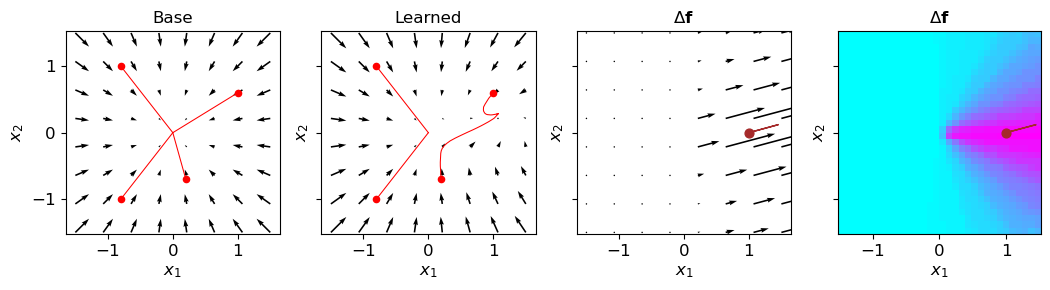

In [4]:
N = 2000
J_PSI = 5*np.random.randn(N, 2)
K = 50
_, ker = make_psi_rand_tanh_k_wta(J_PSI, K)

# single fixed point
x_stars = np.array([ [1., 0]]) 
alphas =  np.array([ [1.5, 0.4]]) 

fig, axs = run_plot_smln(ker, x_stars, alphas, x_inits)
fig.savefig('ms/1_demo_dynamics.svg')